### Import Dependencies and Data

In [1]:
## Create a conda environment with the requirements.txt file attached to it
# !pip install -r requirements.txt

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# !nvidia-smi

In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8488048818172011803
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5712642048
locality {
  bus_id: 1
  links {
  }
}
incarnation: 667247367624394360
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
]


In [6]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [8]:
ds = tfds.load('cifar10', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\amanc\tensorflow_datasets\cifar10\3.0.2.incompleteNDXTFE\cifar10-train.tfrecord*...:   0%| …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\amanc\tensorflow_datasets\cifar10\3.0.2.incompleteNDXTFE\cifar10-test.tfrecord*...:   0%|  …

Dataset cifar10 downloaded and prepared to C:\Users\amanc\tensorflow_datasets\cifar10\3.0.2. Subsequent calls will reuse this data.


In [10]:
ds

<PrefetchDataset shapes: {id: (), image: (32, 32, 3), label: ()}, types: {id: tf.string, image: tf.uint8, label: tf.int64}>

In [14]:
ds.as_numpy_iterator().next().keys()

dict_keys(['id', 'image', 'label'])

In [19]:
ds.as_numpy_iterator().next()['image']

array([[[143,  96,  70],
        [141,  96,  72],
        [135,  93,  72],
        ...,
        [ 96,  37,  19],
        [105,  42,  18],
        [104,  38,  20]],

       [[128,  98,  92],
        [146, 118, 112],
        [170, 145, 138],
        ...,
        [108,  45,  26],
        [112,  44,  24],
        [112,  41,  22]],

       [[ 93,  69,  75],
        [118,  96, 101],
        [179, 160, 162],
        ...,
        [128,  68,  47],
        [125,  61,  42],
        [122,  59,  39]],

       ...,

       [[187, 150, 123],
        [184, 148, 123],
        [179, 142, 121],
        ...,
        [198, 163, 132],
        [201, 166, 135],
        [207, 174, 143]],

       [[187, 150, 117],
        [181, 143, 115],
        [175, 136, 113],
        ...,
        [201, 164, 132],
        [205, 168, 135],
        [207, 171, 139]],

       [[195, 161, 126],
        [187, 153, 123],
        [186, 151, 128],
        ...,
        [212, 177, 147],
        [219, 185, 155],
        [221, 187, 157]]

### Viz Data and Build Dataset

In [20]:
import numpy as np

In [29]:
data_iterator = ds.as_numpy_iterator()

In [30]:
data_iterator.next()

{'id': b'train_16399',
 'image': array([[[143,  96,  70],
         [141,  96,  72],
         [135,  93,  72],
         ...,
         [ 96,  37,  19],
         [105,  42,  18],
         [104,  38,  20]],
 
        [[128,  98,  92],
         [146, 118, 112],
         [170, 145, 138],
         ...,
         [108,  45,  26],
         [112,  44,  24],
         [112,  41,  22]],
 
        [[ 93,  69,  75],
         [118,  96, 101],
         [179, 160, 162],
         ...,
         [128,  68,  47],
         [125,  61,  42],
         [122,  59,  39]],
 
        ...,
 
        [[187, 150, 123],
         [184, 148, 123],
         [179, 142, 121],
         ...,
         [198, 163, 132],
         [201, 166, 135],
         [207, 174, 143]],
 
        [[187, 150, 117],
         [181, 143, 115],
         [175, 136, 113],
         ...,
         [201, 164, 132],
         [205, 168, 135],
         [207, 171, 139]],
 
        [[195, 161, 126],
         [187, 153, 123],
         [186, 151, 128],
         .

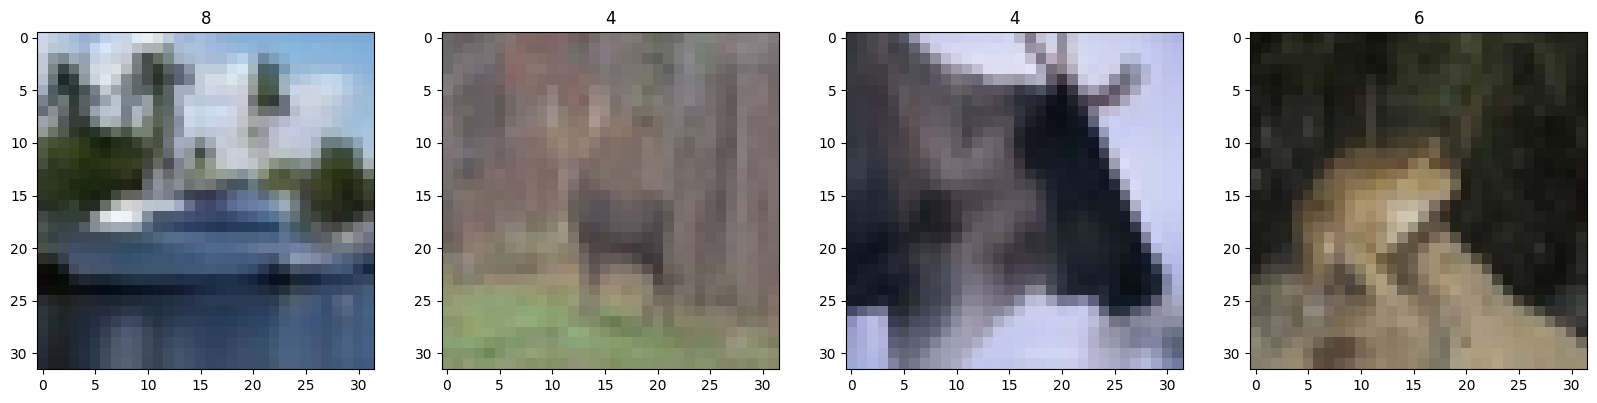

In [31]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    batch = data_iterator.next()
    ax[idx].imshow(np.squeeze(batch['image']))
    ax[idx].title.set_text(batch['label'])

In [32]:
def scale_images(data):
    image = data['image']
    return image / 255

In [33]:
# pipeline
ds = ds.map(scale_images) # scale image preprocessing step
ds = ds.cache() # cache the dataset
ds = ds.shuffle(60000) # shuffle it up
ds = ds.batch(128) # batch into 128 images
ds = ds.prefetch(64) # reduces the likelihood of bottlenecking

In [35]:
ds.as_numpy_iterator().next().shape

(128, 32, 32, 3)

### Build Neural Network

1. Import Modelling Components

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

2. Build Generator

In [41]:
def build_generator():
    model = Sequential()
    
    # Takes in random values and reshapes it to (8,8,128)
    model.add(Dense(8*8*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((8,8,128)))
    
    # Upsampling (16,16,128)
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling (32,32,128)
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convulational block
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Final layer for (32,32,3)
    model.add(Conv2D(3, 4, padding='same', activation='sigmoid'))
        
    return model

In [44]:
generator = build_generator()

In [45]:
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
up_sampling2d_4 (UpSampling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 128)       409728    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 32, 32, 128)      

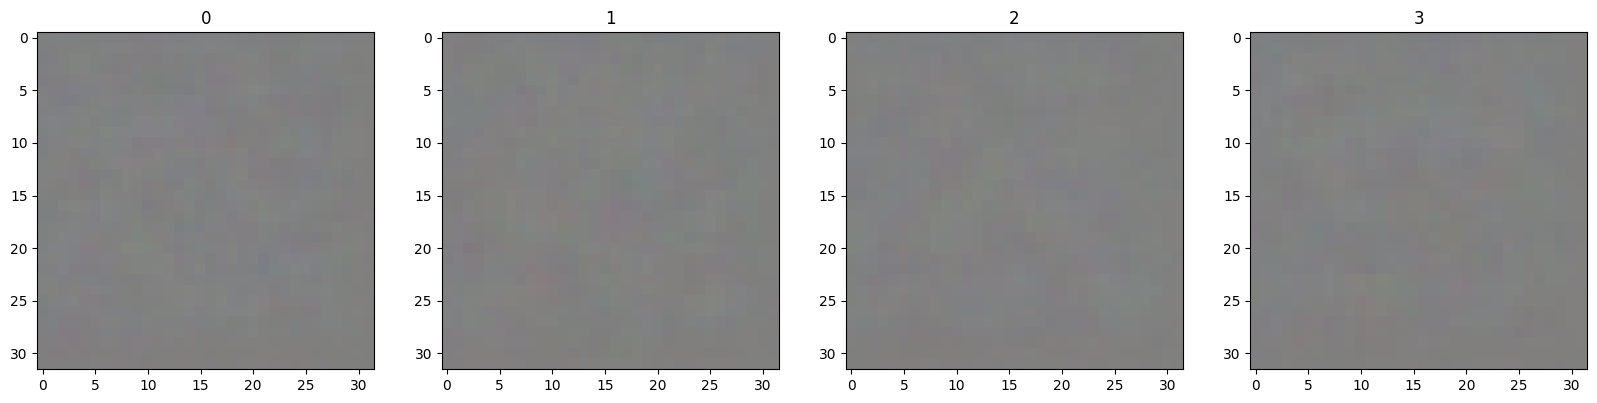

In [52]:
img = generator.predict(np.random.randn(4,128))
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

3. Build Discriminator

In [65]:
def build_discriminator():
    model = Sequential()
    
    # Conv Block
    model.add(Conv2D(32, 5, input_shape=(32,32,3)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4)) 
    
    # Flatten and pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
        
    return model

In [66]:
discriminator = build_discriminator()

In [67]:
discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 28, 28, 32)        2432      
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 28, 28, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 24, 24, 64)        51264     
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 20, 20, 128)      

In [70]:
img = generator.predict(np.random.randn(4, 128))

In [71]:
img.shape

(4, 32, 32, 3)

In [72]:
discriminator.predict(img)

array([[0.50077826],
       [0.5010064 ],
       [0.50078577],
       [0.50107235]], dtype=float32)

### Construct Training Loop

1. Setup Losses and Optimizers

In [73]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [74]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

2. Build Subclassed Model

In [75]:
from tensorflow.keras.models import Model

In [89]:
class CifarGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        super().compile(*args, **kwargs)
        
        # Create attributes for optimizers and losses
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss
        
    def train_step(self, batch):
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128)), training=False)
        
        ## Train the discriminator
        with tf.GradientTape() as d_tape:
            ## Pass the real and fake images to discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            ## Create labels for real=0 and fake=1 images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            ## Add some noise to true o/p
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            ## Calculate Loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        ## Apply backpropogation
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        
        ## Train the generator
        with tf.GradientTape() as g_tape:
            ## Generate some images
            gen_images = self.generator(tf.random.normal((128, 128)), training=True)
            
            ## Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
            
            ## Calculate Loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)
            
        ## Apply Backpropogation
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {'d_loss':total_d_loss, 'g_loss':total_g_loss}

In [90]:
cifargan = CifarGAN(generator, discriminator)

In [91]:
cifargan.compile(g_opt, d_opt, g_loss, d_loss)

3. Build Callback

In [92]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [93]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
    
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

4. Train

In [94]:
## Recommend 2000
hist = cifargan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
391/391 [==============================] - 59s 142ms/step - d_loss: 0.5015 - g_loss: 1.4510
Epoch 2/20
391/391 [==============================] - 57s 147ms/step - d_loss: 0.3073 - g_loss: 1.6494
Epoch 3/20
391/391 [==============================] - 61s 157ms/step - d_loss: 0.5772 - g_loss: 1.0110
Epoch 4/20
391/391 [==============================] - 63s 161ms/step - d_loss: 0.3920 - g_loss: 3.8216
Epoch 5/20
391/391 [==============================] - 66s 168ms/step - d_loss: 0.3972 - g_loss: 0.4944
Epoch 6/20
391/391 [==============================] - 66s 169ms/step - d_loss: 0.3009 - g_loss: 0.1340
Epoch 7/20
391/391 [==============================] - 66s 169ms/step - d_loss: 0.2906 - g_loss: 0.1448
Epoch 8/20
391/391 [==============================] - 66s 169ms/step - d_loss: 0.2924 - g_loss: 0.2581
Epoch 9/20
391/391 [==============================] - 67s 171ms/step - d_loss: 0.7025 - g_loss: 0.4289
Epoch 10/20
391/391 [==============================] - 68s 174ms/step - d

5. Review Performance

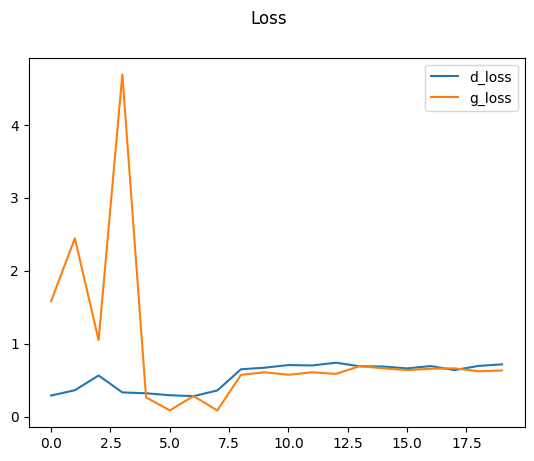

In [95]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

### Test out the Generator

1. Generate Images

In [97]:
imgs = generator.predict(tf.random.normal((16,128)))

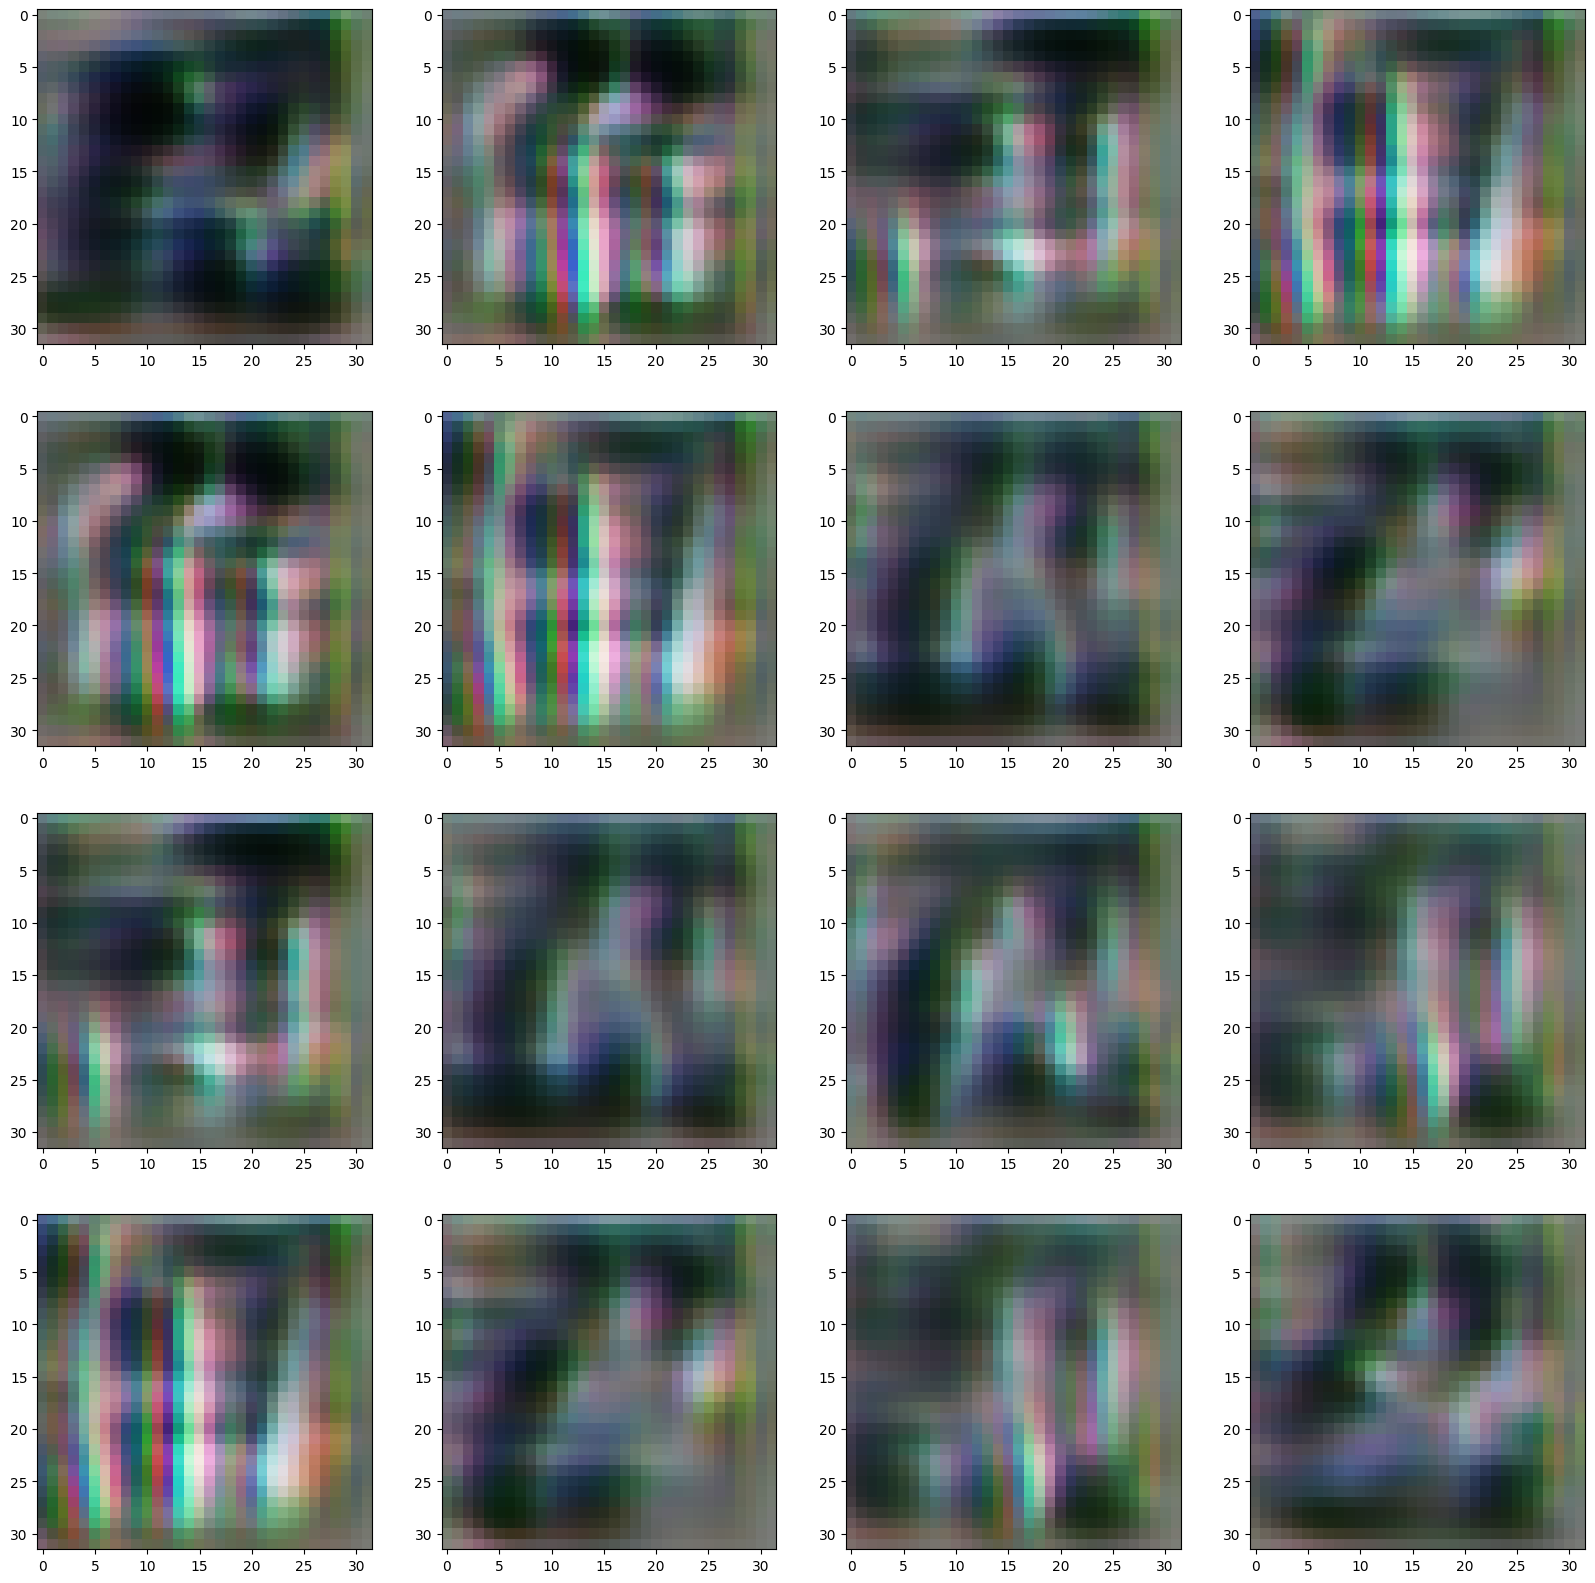

In [99]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(20,20))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

2. Save the model

In [100]:
generator.save('generator_cifar10.h5')
discriminator.save('discriminator_cifar10.h5')